In [268]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
pd.set_option('max_colwidth', 400)

In [421]:
type_data = pd.read_csv("../data/prototypicality/glass_n.csv")

In [422]:
def true_vs_other(row):
    true_sense = row['sense']
    true_sim = row[true_sense]
    max_others = max(row[[c for c in row.index if c not in [true_sense, 'sentence', 'sense']]])
    return true_sim - max_others

In [423]:
type_data['prototypicality'] = type_data.apply(true_vs_other, axis = 1)

In [424]:
def sent_proto(df, fn):
    max_prots = pd.DataFrame(df.groupby('sense')['prototypicality'].agg(fn)).reset_index()
    sentences = []
    for s in max_prots['sense']:
        prot = max_prots[max_prots['sense'] == s]['prototypicality'].values[0]
        sent = df[(df['prototypicality'] == prot) & (df['sense'] == s)]['sentence'].values[0]
        sentences.append(sent)
    max_prots['sentence'] = sentences
    return max_prots

In [425]:
sent_proto(type_data, 'min')

,sense,prototypicality,sentence
0,glass.n.01,-0.075803,"It is not an entirely happy book , as Mrs. Fink soon becomes jealous of Alicia and , in retaliation , refuses to continue to scrape the algae off her glass ."
1,glass.n.02,-0.190047,The suburban branch is thereby credited with a sale which would have been made even if its glass doors had never opened .
2,glass.n.03,0.070885,Lord Byron poured himself another glass of wine and held it up to the candle flame admiring the rich color .


In [426]:
sent_proto(type_data, 'max')

,sense,prototypicality,sentence
0,glass.n.01,0.287352,"The photochemical reaction cells consisted of 10 mm. i.d. Pyrex tubing , 5.5 cm. long , diffraction effects being minimized by the fact that the light passed through only liquid glass interfaces and not gas glass interfaces ."
1,glass.n.02,0.159501,"She filled a big pitcher and set it , with glasses , on a tray ."
2,glass.n.03,0.135136,"After Captain Docherty sent Arleigh Griffith for Hoag he was able to complete his detailed inspection of the third floor and to receive a report from his man covering the floors above before Griffith returned , buoyed up by a brief stop for another glass of champagne ."


## MFS Analysis

Could the most frequent sense be having an effect on prototypicality ratings? From discussion of "Modeling word interpretation with deep language models" by Aina et al (2020). Here, we look at the rank of the most frequent sense's centroid when computing prototypicality ratings. For vectors representing all but the MFS, we compute its cosine similarity with all the sense centroids, and extract the rank of the MFS's similarity. If we divide it by the number of senses, we get the percentile. 

We find that MFS is above the median cosine similarity for 78.5% of the vectors (1 vector for each instance).

In [427]:
def mfs_rank(row, mfs):
    other_senses = [c for c in row.index if c not in ['sentence', 'sense', 'prototypicality', 'mfs_rank']]
    sense_dists = [(c, row[c]) for c in other_senses]
    sorted_dists = sorted(sense_dists, key = lambda t: t[1])
    return ([i for i in range(len(sorted_dists)) if sorted_dists[i][0] == mfs][0] + 1) / len(other_senses)

In [428]:
def mfs_dist(type_df):
    mfs = np.argmax(type_df['sense'].value_counts())
    other_senses = type_df[type_df['sense'] != mfs]
    mfs_ranks = other_senses.apply(mfs_rank, args = (mfs,), axis = 1)
    return list(mfs_ranks)

In [429]:
mfs_pct_ranks = []
for fname in os.listdir(os.path.join('..', 'data', 'prototypicality')):
    type_df = pd.read_csv(os.path.join('..', 'data', 'prototypicality', fname))
    if type(mfs_dist(type_df)[0]) == float:
        mfs_pct_ranks += mfs_dist(type_df)


Text(0.5, 1.0, 'Distribution of MFS Rank Percentile')

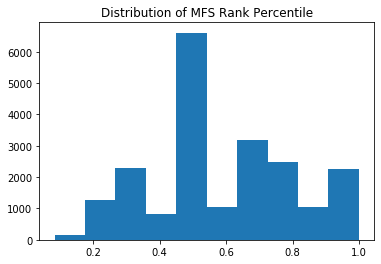

In [354]:
plt.hist(mfs_pct_ranks)
plt.title("Distribution of MFS Rank Percentile")

In [334]:
np.count_nonzero(np.array(mfs_pct_ranks) >= 0.5) / len(mfs_pct_ranks)

0.7850405583852104

## Checking against Lower Dimensionalities

### Important Weights from Logistic Regression

In [430]:
type_data = pd.read_csv("../data/prototypicality_stimuli/glass_n.csv")
type_data['prototypicality'] = type_data.apply(true_vs_other, axis = 1)

In [431]:
sent_proto(type_data, 'min')

,sense,prototypicality,sentence
0,glass.n.01,0.020914,"It is not an entirely happy book , as Mrs. Fink soon becomes jealous of Alicia and , in retaliation , refuses to continue to scrape the algae off her glass ."
1,glass.n.02,-0.026633,"There was a glass pane in the front door , and through this he could see into a hallway where a plump woman with red hair was arranging flowers ."
2,glass.n.03,0.073009,Lord Byron poured himself another glass of wine and held it up to the candle flame admiring the rich color .


In [432]:
sent_proto(type_data, 'max')

,sense,prototypicality,sentence
0,glass.n.01,0.195002,"He lived in an apartment house not over three or four years old , a reclaimed island of landscaped brick and glass on the fringe of the business district ."
1,glass.n.02,0.118872,"I asked , taking a final gulp of my drink , and handing him the empty glass ."
2,glass.n.03,0.087689,"After Captain Docherty sent Arleigh Griffith for Hoag he was able to complete his detailed inspection of the third floor and to receive a report from his man covering the floors above before Griffith returned , buoyed up by a brief stop for another glass of champagne ."


### PCA

In [434]:
os.listdir('../data/prototypicality_pca/')

['offer_v.csv',
 'claim_n.csv',
 'determine_v.csv',
 'way_n.csv',
 'action_n.csv',
 'long_a.csv',
 'report_v.csv',
 'speak_v.csv',
 'together_r.csv',
 'son_n.csv',
 'season_n.csv',
 'plan_n.csv',
 'production_n.csv',
 'mind_n.csv',
 'wrong_a.csv',
 'professional_a.csv',
 'investigate_v.csv',
 'value_n.csv',
 'stand_v.csv',
 'voice_n.csv',
 'do_v.csv',
 'remember_v.csv',
 'skill_n.csv',
 'wish_v.csv',
 'serve_v.csv',
 'notion_n.csv',
 'extend_v.csv',
 'accept_v.csv',
 'declare_v.csv',
 'set_n.csv',
 'floor_n.csv',
 'sense_n.csv',
 'degree_n.csv',
 'level_n.csv',
 'difficulty_n.csv',
 'require_v.csv',
 'cover_v.csv',
 'phase_n.csv',
 'job_n.csv',
 'move_v.csv',
 'love_v.csv',
 'back_r.csv',
 'imply_v.csv',
 'operation_n.csv',
 'turn_v.csv',
 'agree_v.csv',
 'marriage_n.csv',
 'mark_v.csv',
 'pass_through_v.csv',
 'contrast_n.csv',
 'design_n.csv',
 'end_n.csv',
 'talk_v.csv',
 'announce_v.csv',
 'keep_v.csv',
 'spread_v.csv',
 'information_n.csv',
 'play_v.csv',
 'break_v.csv',
 'shot_n.

In [438]:
type_data = pd.read_csv("../data/prototypicality_pca/floor_n.csv")
type_data['prototypicality'] = type_data.apply(true_vs_other, axis = 1)

In [439]:
sent_proto(type_data, 'min')

,sense,prototypicality,sentence
0,floor.n.01,-0.160748,"The front windows of the place were long and narrow , reaching nearly to the floor and affording an unusually good view of the interior ."
1,floor.n.02,-0.387170,"The debris of his other careers was piled everywhere ; a pile of wire cages for mice from his time as a geneticist and a microscope lying on its side on the window sill , vertical steel columns wired for support to the open ceiling beams with spidery steel cantilevers jutting out into the air , masonry constructions on the floor from the time he was inventing his disastrous fireplace whose smo..."


In [440]:
sent_proto(type_data, 'max')

,sense,prototypicality,sentence
0,floor.n.01,1.378252,"He paced slowly , stooping , staring at the damp , slippery floor ."
1,floor.n.02,1.809031,The cops would gather up Connor and the foursome on the third floor and bring us those of them who would voluntarily submit to fingerprinting .


PCA appears to give off the strongest signal for an instance of a sence being more "prototypical" but the actual sentences don't show more/less prototypical uses of the sense.